# Filtrage collaboratif

*ismael Bonneau*

Le filtrage collaboratif (en anglais: collaborative filtering) est une méthode utilisée par les systèmes de recommandations.

Une méthode de recommandation classique et de recommander à un utilisateur des objets similaires de celui qu'il a déjà aimé. Cette similarité, dans le cas d'une série ou d'un film par exemple peut se baser sur le genre, les acteurs en commun, le synopsis... Ainsi, si un utilisateur a aimé la série the punisher et luke cage, le système lui recommandera daredevil, shield agents, etc...
Cette stratégie a un défaut: les recommandations manquent de diversité et n'incitent pas l'utilisateur à explorer le catalogue.

Une deuxième approche est le **filtrage collaboratif**:
il permet de réaliser des prédictions automatiques ("filtrage") des intérêts d'un utilisateur en se basant sur les préférences d'un grand nombre d'autres utilisateurs ("collaboratif"), afin de recommander des produits (films, séries, musique, articles sur un site de e-commerce...) pertinents pour un utilisateur.

<img src="images/homer.png" width="500" />

-------------------------------------------------------------------------

### Principe:

L'hypothèse sous-jacente du filtrage collaboratif est que si une personne A a la même opinion qu'une personne B sur un sujet, A a plus de chance d'avoir la même opinion que B sur un autre sujet qu'une personne choisie au hasard.

Le système commence donc d'abord par collecter des avis d'un grand nombre d'utilisateurs sur un grand nombre d'objets (dans notre cas, des séries). Cet avis peut prendre plusieurs formes (1-5 étoiles, note sur 10, j'aime/je n'aime pas...) 

Puis, pour un utilisateur A le système trouve les utilisateurs qui ont les goûts les plus similaires. A partir des goûts de ces utilisateurs les plus similaires, le système peut prédir à l'utilisateur A une note pour chacun des objets qu'il n'a pas noté. 

Plusieurs types d'approche existent:

1) l'approche dite **memory-based**:
<p>
    Cette approche utilise les notes attribuées par les utilisateurs pour calculer la similarité entre les utilisateurs ou les objets. Elle se base sur un calcul de similarité et utilise des algorithmes classiques comme:
    <ul>
        <li>K plus proches voisins (K-NN) <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">wikipédia</a></li>
        <li>Des mesures de similarité comme la similarité cosinus, la corrélation de Pearson...
            <a href=""></a></li>
    </ul>
</p>

2) l'approche dite **model-based**: 
<p>
    Cette approche utilise des techniques de machine learning et de data mining pour attribuer des notes couples utilisateur-objet. 
<ul>
    <li>Analyse en composantes principales (PCA) <a href="https://en.wikipedia.org/wiki/Singular_value_decomposition">wikipédia</a></li>
    <li>Factorisation de matrice non négative (NNMF) <a href="https://en.wikipedia.org/wiki/Non-negative_matrix_factorization">wikipédia</a></li>
    <li>Bayesian Personalized Ranking (n'attribue pas de "notes" mais un classement) <a href="https://cran.r-project.org/web/packages/rrecsys/vignettes/b6_BPR.html">lien</a></li>
    <li>...Et bien d'autres (approches à base de clustering...)</li>
</ul>
</p>

pour en savoir plus sur le filtrage collaboratif: <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">wikipédia (en anglais)</a>

<img src="images/Classification-of-collaborative-filtering-algorithms.png" width="600" />

image sources:

<a href="https://www.researchgate.net/profile/Kan_Zheng/publication/303556519/figure/fig4/AS:614297214414873@1523471277992/Classification-of-collaborative-filtering-algorithms.png">[1]</a> <a href="https://johnolamendy.wordpress.com/2015/10/14/collaborative-filtering-in-apache-spark/">[2]</a>

-------------------

### Notre but:

Nous allons mettre en oeuvre et comparer plusieurs approches de recommandation collaborative, en l'occurence les approches model-based. 

Notre but est d'implémenter et comparer qualitativement et quantitativement les algorithmes de factorisation de matrice non négative (NNMF), décomposition en valeurs singulières (SVD), Bayesian Personalized Ranking, et différentes fonctions de coûts associées, sur un jeu de données collectés sur le site imdb.

### Données:

Nous partons d'une base de ${m = 48705}$ utilisateurs ayant noté ${n = 892}$ séries. Ces données sont extraites du site <a href="https://www.imdb.com/">imdb</a> (voir script scraping/scraping.py) et sont résumées dans une matrice de taille ${n,m}$ où chaque entrée ${(u, i)}$ de matrice contient la note que l'utilisateur ${u}$ a attribué à l'item (série) ${i}$, sur 10 (le site ayant choisi un système de notation sur 10 étoiles).

---------------------

### Rentrons dans le vif du sujet:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix, csr_matrix #matrice "sparse"
import seaborn as sns

sns.set(color_codes=True)
plt.style.use('seaborn-white')
%matplotlib inline

filename = "userratings.csv"
tableSeries = "series.csv"

### Récupérons les avis utilisateur

In [92]:
df = pd.read_csv(filename)
print("il y a {} utilisateurs et {} séries".format(df.shape[1], df.shape[0]))

il y a 48705 utilisateurs et 892 séries


**Ci dessous**, les premières lignes de la matrice, avec en ligne les séries et en colonne les utilisateurs. On peut voir que la plupart des cases sont vides (NaN), les utilisateurs n'ayant noté que très peu de séries.

In [115]:
df.head(4)

,bkoganbing,killer1h,santasa99,qui_j,BeneCumb,DegustateurDeChocolat,SonicStuart,DKosty123,jazebelle,insomniac_rod,...,chris_willson,michael-schaefer-34219,kevinmorice,mendelson77,pninson,montferrato,limona_razvan,kythia,Skylightmovies,bbgrl93
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Jetons un oeil à la distribution des données:

In [69]:
for seuil in [1, 5, 10]:
    c = len([a for a in (df.count(axis=0) > seuil) if a])/df.shape[1]
    print("{0:.2f}% des utilisateurs ont noté plus de ".format(
        100*c)+str(seuil)+" série ("+str(int(c*df.shape[1]))+" total)")
print("\n")   
for seuil in [2, 20, 50, 100]:
    c = len([a for a in (df.count(axis=1) > seuil) if a])/df.shape[0]
    print("{0:.2f}% des series ont reçu plus de ".format(
        100*c)+str(seuil)+" notes ("+str(int(c*df.shape[0]))+" total)")

13.55% des utilisateurs ont noté plus de 1 série (6598 total)
1.38% des utilisateurs ont noté plus de 5 série (670 total)
0.46% des utilisateurs ont noté plus de 10 série (226 total)


98.54% des series ont reçu plus de 2 notes (879 total)
69.62% des series ont reçu plus de 20 notes (621 total)
35.87% des series ont reçu plus de 50 notes (320 total)
19.28% des series ont reçu plus de 100 notes (172 total)


<img src="images/distribution_avis.png" width="900" />

L'histogramme révèle que les utilisateurs donnent très peu d'avis: 86,5% d'entre eux n'ont noté qu'une série. Les séries ont quant à elle plus d'avis: près de 20% des séries ont reçu plus de 100 notes, et 70% des séries ont reçu au moins 20 notes. Il faut choisir un **seuil de coupure** pour éliminer les utilisateurs ayant trop peu noté: nous choisissons arbitrairement de couper en-dessous de 4. Pour les séries, on gardera celles ayant reçu au moins 4 notes.

<img src="images/distribution_notes.png" />

In [99]:
series = pd.read_csv(tableSeries)
series = series[["seriesname", "imdbId"]]

Retirons les noms de série, et enlevons les utilisateurs ayant noté moins de 4 séries et les séries notées moins de 4 fois:

In [100]:
#nous allons réaliser un mapping des imdbId de séries vers des entiers.
#on mémorise le mapping entier -> série en gardant les noms de série.
df.rename(columns={"Unnamed: 0":'item'}, inplace=True)
df = df.loc[:, (df.count(axis=0) >= 4)] #enlever les utilisateurs ayant noté moins de 5 séries
df = df.loc[(df.count(axis=1) >= 4), :] #enlever les séries ayant reçu moins de 4 notes

In [101]:
serie_dict = []
for imdbId in df["item"]:
    serie_dict.append(list(series[series["imdbId"] == imdbId]["seriesname"])[0])
    
df = df.drop(columns=['item']) #enlever la colonne des noms de série
df = df.transpose()

<img src="images/distribution_notes_apresfiltrage.png" />

### Masquage des valeurs manquantes:

Nous allons créer une variable "masque" booléen, qui nous servira pour l'étape suivante. On obtient un tableau de même dimension, dans lequel False indique une valeur manquante (à masquer pour la suite) et True une valeur observée.

In [102]:
mask = df.notnull()
mask.head()

,0,1,2,3,4,5,6,7,8,10,...,876,879,880,881,882,883,884,887,888,889
bkoganbing,False,False,True,False,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
killer1h,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
santasa99,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
qui_j,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BeneCumb,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


### Matrix Factorization: principe

Une des façons de faire du filtrage collaboratif par approche model-based est d'utiliser un algorithme de **factorisation de matrice**. 

On pose ${\mathbf{R}}$ la matrice des notes, $\mathbf{\hat{R}}$ la matrice que l'on cherche à construire, contenant toutes les notes existantes et prédites. Cette matrice est de dimension ${m, n}$ avec ${m}$ le nombre d'utilisateurs et ${n}$ le nombre de séries. On va chercher à trouver deux matrices "facteur" $\mathbf{U}$ et $\mathbf{I}$ de dimension ${m, k}$ et ${k, n}$ de telle sorte que $\mathbf{\hat{R}}=\mathbf{U}\cdot\mathbf{I}$ avec ${\mathbf{\hat{R}} \approx \mathbf{R}}$

<img src="images/collaborative_filtering.png" width="400" />

Les dimensions ${m}$ et ${n}$ étant connues à l'avance, c'est la dimension ${k}$ qu'il reste à fixer, et définir une "fonction" mathématique qui mesure à quel point les deux matrice $\mathbf{R}$ (reconstituée) et la matrice originale sont proches.

Ainsi, et d'après la définition du produit matriciel, chaque case de la matrice $R_{i,j}$ résultante est le résultat d'une combinaison linéaire de $U_{i,}$ et $I_{,j}$, c'est à dire d'un vecteur de dimension ${k}$ représentant l'utilisateur ${i}$ et d'un vecteur de dimension ${k}$ représentant l'item ${j}$.

Il s'agit donc de projeter les utilisateurs et les items dans un espace de dimension ${k}$ ! On dit aussi qu'on apprend des _profils utilisateur_ et des _profils item_ sur ${k}$ variables latentes.

Plusieurs algorithmes peuvent servir à réaliser une factorisation de matrice.

### NMF (non negative matrix factorization): 

Un algorithme de factorisation de matrice simple. L'algorithme consiste en une descente de gradient sur une fonction d'erreur. L'algorithme ne tient pas compte des valeurs manquantes: Il effectue une descente de gradient uniquement sur les valeurs observées. Il "apprend" donc les relations entre items et utilisateurs sur les valeurs observées, pour ensuite pouvoir prédire les valeurs manquantes.

On apprend donc deux matrices ${U}$ et ${I}$. 
la fonction d'erreur est ${e = ||(R -\hat{R})^2|| + \beta (||U||^2 + ||I||^2)}$.

${\beta}$ est le paramètre de régularization. Il nécessite d'être ajusté. Il sert à contrôler la "taille" des paramètres appris U et I en empêchant qu'ils deviennent trop grands, afin de s'assurer que l'on utilise que les variables latentes utiles. Pour en savoir plus sur la régularisation en machine learning: <a href="">lien</a> 

La particularité de l'algorithme est qu'il intègre une contrainte sur les valeurs des matrices ${U}$ et ${I}$: elles doivent être **positives** (d'où le "non negative").<br>
On a donc ${U_{i,k} \geq 0}$ ${\forall{(i,k)} \in \{1, ...,m\} \times \{1, ...,k\}}$ et ${I_{k,j} \geq 0 \forall{(k,j)} \in \{1, ...,k\} \times \{1, ...,n\}}$.

Cette contrainte de non-négativité, qui fait la particularité de NMF présente deux avantages: 1) le modèle obtenu est expliquable: puisque les affinités sont toutes additives, on comprend plus aisément comment les intérêts se combinent entre eux.

##### petit problème: données manquantes

Un petit problème se pose dans la partie applicative: la matrice ${R}$ contient des données manquantes qui sont, dans une matrice sparse, interprétés comme des 0. Ce ne sont pourtant pas des notes de 0 mais bien une **absence de note** (notez la différence). Les implémentations des algorithmes de factorisation de matrice de scikit-learn ne prennent pas ce point en compte et cherchent à prédire des 0 à la place des valeurs manquantes. On ne peut donc pas utiliser les implémentations de scikit-learn et il faut définir notre propre implémentation (ou utiliser gensim/surprise).

### Implémentation dans tensorflow:

In [103]:
import tensorflow as tf #ou n'importe quel autre framework de DL

In [143]:
def mse(xptdr):
    true = []
    pred = []
    for i in range(df.values.shape[0]):
        for j in range(df.values.shape[1]):
            if not np.isnan(df.values[i,j]):
                true.append(df.values[i,j])
                pred.append(xptdr[i,j])
    true = np.array(true)
    pred = np.array(pred)
    mse = np.mean((true - pred)**2)
    return mse

#latent factors
k = 5 
shape = df.shape

#biais global: moyenne de toutes les notes
b = tf.constant(df.T.stack().values.mean(), name='bias')

#biais utilisateur: vecteur de dimension (1, m)
#initialisé avec la moyenne des notes de chaque utilisateur
bU = tf.Variable(df.mean(axis=0).values.astype(np.float64), name="bU")

#biais item: vecteur de dimension (n, 1)
#initialisé avec la moyenne des notes de chaque item
bI = tf.Variable(df.mean(axis=1).values.astype(np.float64).T.reshape(-1,1), name="bI")

#constante: la matrice R à reconstituer entièrement
R = tf.constant(df.values / 10)

#variable tensorflow masque
mask_tf = tf.Variable(mask.values)

#variables tensorflow
#U et I initialisés selon une loi normale et normalisés en divisant par k
U = tf.Variable(np.random.normal(scale=1./k, size=(shape[0], k)).astype(np.float64), name="U")
I =  tf.Variable(np.random.normal(scale=1./k, size=(k, shape[1])).astype(np.float64), name="I")

#R_pred = b + bI + bU + tf.matmul(U, I)
R_pred = tf.matmul(U, I)

#beta: paramètre de regularization
beta = tf.constant(0.05, dtype=tf.float64, name="beta")

#cout de l'algo NMF, norme matricielle de R - R_pred
cost = tf.reduce_sum(tf.pow(tf.boolean_mask(R, mask_tf) - tf.boolean_mask(R_pred, mask_tf), 2)) \
+ beta * (tf.reduce_sum(tf.pow(U, 2)) + tf.reduce_sum(tf.pow(I, 2)))

#contraintes de non-négativité de U et I
clip_U = U.assign(tf.maximum(tf.zeros_like(U), U))
clip_I = I.assign(tf.maximum(tf.zeros_like(I), I))
clip = tf.group(clip_U, clip_I)

alpha = 0.001 #learning rate

optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(cost)
init = tf.global_variables_initializer()

steps = 1000
costs = []
mses = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        sess.run(optimizer)
        sess.run(clip)
        if i%100==0:
            prout = sess.run(cost)
            #print("\nCost: %f" % prout)
            #print("*"*40)
            costs.append((i, prout))
            learnt_U = sess.run(U)
            learnt_I = sess.run(I)
            xptdr = np.round(np.dot(learnt_U, learnt_I) * 10)
            mses.append(mse(xptdr))
            
    learnt_U = sess.run(U)
    learnt_I = sess.run(I)
    #learnt_bU = sess.run(bU)
    #learnt_bI = sess.run(bI)

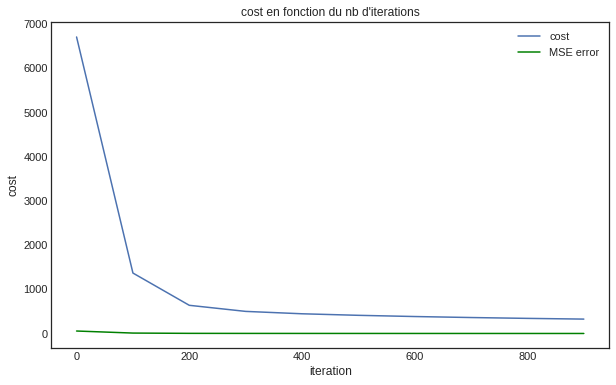

In [145]:
plt.figure(figsize=(10,6))
plt.title("cost en fonction du nb d'iterations")
plt.xlabel("iteration")
plt.ylabel("cost")
plt.plot([a for a,b in costs], [b for a,b in costs], label="cost")
plt.plot([a for a,b in costs], mses, color="green", label="MSE error")
plt.legend()
plt.show()

In [146]:
xptdr = np.round(np.dot(learnt_U, learnt_I) * 10)

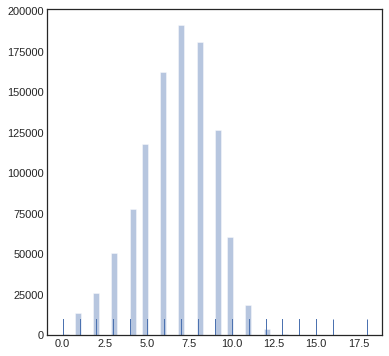

In [147]:
plt.figure(figsize=(6,6))
sns.distplot(xptdr.flatten(), kde=False, rug=True)
plt.show()

In [130]:
df.values.shape

(1423, 726)

On obtient bien la matrice reconstituée dans les dimensions voulues!

### visualisons le résultat:

Les matrices ${U}$ et ${I}$ apprises par NMF nous donnent une information:

In [69]:
learnt_I.shape

(5, 726)

In [38]:
#sauvegarde des embeddings appris pour les visualiser dans tensorboard
np.savetxt(f"imdb_vectors.tsv", learnt_I.transpose(), delimiter="\t")
with open(f"imdb_metadata.tsv","w") as metadata_file:
    for x in serie_dict: #hack for space
        x = " ".join(x.split("_")[1:])
        if len(x.strip()) == 0:
            x = f"space-{len(x)}"
        metadata_file.write(f"{x}\n")

### Avec k=10

visualisation PCA en 3D, variance expliquée 59.6%

<img src="images/pca_1.png" />

In [ ]:
for i in range(k):
    lol = np.argsort(learnt_I.transpose()[:, i])[::-1][:5]
    print("profil item %d" % (i+1))
    for j in range(5):
        print("\t\t"+" ".join(serie_dict[lol[j]].split("_")[1:]))